# Explore Discharge Predictions (CamelsGB)

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch 

base_dir = Path(".").absolute().parents[0]
import sys

if sys.path[0] != base_dir.as_posix():
    sys.path = [base_dir.as_posix()] + sys.path

In [2]:
from spatio_temporal.config import Config
from spatio_temporal.training.trainer import Trainer
from spatio_temporal.training.tester import Tester
from tests.utils import (
    create_linear_ds,
    _test_sklearn_model,
    download_test_jena_data,
    load_test_jena_data_as_dataset
)
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_losses

# Load in config file and predictions

In [36]:
# run_results_dir = base_dir / "runs/runoff_subset_2505_161255"
run_results_dir = base_dir / "runs/runoff_2505_163935"
# run_results_dir = base_dir / "runs/runoff_cycle_lstm/"

cfg = Config(run_results_dir / "config.yml")
cfg

{'autoregressive': False,
 'batch_size': 256,
 'clip_gradient_norm': None,
 'constant_mean': None,
 'constant_std': None,
 'data_dir': PosixPath('/home/tommy/spatio_temporal/data'),
 'data_path': PosixPath('/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc'),
 'device': 'cuda:0',
 'dropout': 0.4,
 'early_stopping': None,
 'encode_doys': False,
 'experiment_name': 'runoff',
 'forecast_variables': None,
 'hidden_size': 64,
 'horizon': 0,
 'input_variables': ['temperature', 'precipitation'],
 'learning_rate': 0.01,
 'loss': 'MSE',
 'model': 'lstm',
 'n_epochs': 50,
 'normalize_variables': None,
 'num_workers': 4,
 'optimizer': 'Adam',
 'pixel_dims': ['station_id'],
 'run_dir': PosixPath('/home/tommy/spatio_temporal/runs/runoff_2505_163935'),
 'scheduler': 'cycle',
 'seed': 1234,
 'seq_length': 356,
 'static_data_path': PosixPath('/home/tommy/spatio_temporal/data/camels_static.nc'),
 'static_inputs': ['p_mean', 'pet_mean', 'area', 'gauge_elev'],
 'target_variable': 'discharge_spec',
 'tes

In [37]:
ds = xr.open_dataset(base_dir / "data/ALL_dynamic_ds.nc")
ds

<xarray.Dataset>
Dimensions:         (station_id: 671, time: 16436)
Coordinates:
  * station_id      (station_id) int64 1001 2001 2002 ... 102001 106001 107001
  * time            (time) datetime64[ns] 1970-10-01 1970-10-02 ... 2015-09-30
Data variables:
    precipitation   (time, station_id) float64 ...
    pet             (time, station_id) float64 ...
    temperature     (time, station_id) float64 ...
    discharge_spec  (time, station_id) float64 ...
    discharge_vol   (time, station_id) float64 ...
    peti            (time, station_id) float64 ...
    humidity        (time, station_id) float64 ...
    shortwave_rad   (time, station_id) float64 ...
    longwave_rad    (time, station_id) float64 ...
    windspeed       (time, station_id) float64 ...

In [38]:
import pickle 

normalizer = pickle.load((run_results_dir / "normalizer.pkl").open("rb"))

In [39]:
updated_mean = normalizer.mean_.copy()
updated_mean

<xarray.Dataset>
Dimensions:         (sample: 671)
Coordinates:
  * sample          (sample) <U13 '1001_1001' '2001_2001' ... '107001_107001'
Data variables:
    temperature     (sample) float64 7.848 7.193 6.972 ... 9.873 8.293 7.595
    precipitation   (sample) float64 2.553 3.058 3.445 ... 2.77 4.355 3.325
    discharge_spec  (sample) float64 1.446 1.908 2.271 4.121 ... 1.476 2.731 nan

# Are the train Test Periods equivalent?
- test period is wetter

In [ ]:
test = ds.sel(time=slice(cfg._cfg["test_start_date"], cfg._cfg["test_end_date"]))
val = ds.sel(time=slice(cfg._cfg["validation_start_date"], cfg._cfg["validation_end_date"]))
train = ds.sel(time=slice(cfg._cfg["train_start_date"], cfg._cfg["train_end_date"]))

finite_flat = lambda arr: arr[np.isfinite(arr)]

scale = 0.5
f, axs = plt.subplots(1, 2, figsize=(12*2*scale, 8*scale))
axs[0].hist(finite_flat(np.log(train.precipitation).values), label="Train", density=True, alpha=0.4, bins=100);
axs[0].hist(finite_flat(np.log(val.precipitation).values), label="Val", density=True, alpha=0.4, bins=100);
axs[0].legend()
axs[0].set_title("Log Precip [mm]")

axs[1].hist(finite_flat(np.log(train.discharge_spec).values), label="Train", density=True, alpha=0.4, bins=100);
axs[1].hist(finite_flat(np.log(val.discharge_spec).values), label="Val", density=True, alpha=0.4, bins=100);
axs[1].set_title("Log Discharge [mm^3 s-1]")

sns.despine()

# Check loss curves

In [41]:
run_dir = cfg.run_dir
assert cfg.run_dir.exists()

<AxesSubplot:>

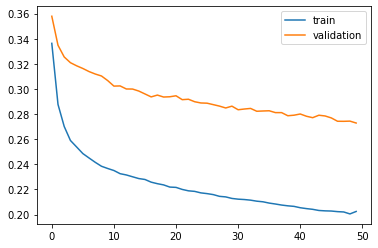

In [42]:
assert (cfg.run_dir / "losses.csv").exists(), f"{list((cfg.run_dir).iterdir())}" 

losses = pd.read_csv(cfg.run_dir / "losses.csv", index_col=0)

losses.plot()

# Explore Predictions

In [43]:
assert run_dir.exists()
run_dir

PosixPath('/home/tommy/spatio_temporal/runs/runoff_2505_163935')

In [57]:
xr_path = sorted(list(run_dir.glob("*.nc")))[-1]
preds = xr.open_dataset(xr_path).drop("horizon")
preds["sim"] = preds["sim"].clip(min=0)
preds

<xarray.Dataset>
Dimensions:  (pixel: 671, time: 3662)
Coordinates:
  * time     (time) datetime64[ns] 1998-12-22T23:59:46.966659072 ... 2008-12-...
  * pixel    (pixel) object '10002_10002' '10003_10003' ... '97002_97002'
Data variables:
    sim      (time, pixel) float64 1.115 1.069 0.9953 ... 1.495 1.577 0.9391
    obs      (time, pixel) float64 ...

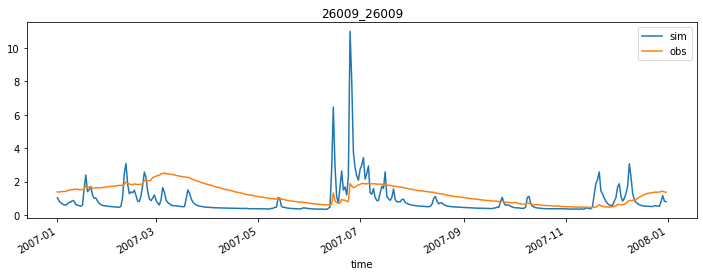

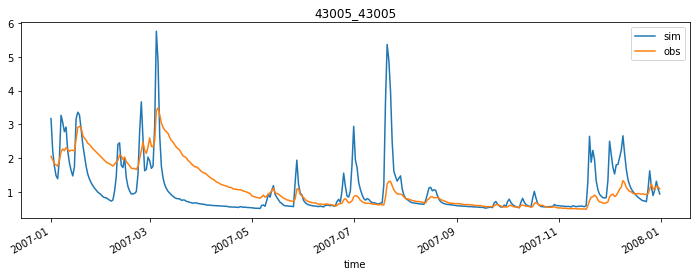

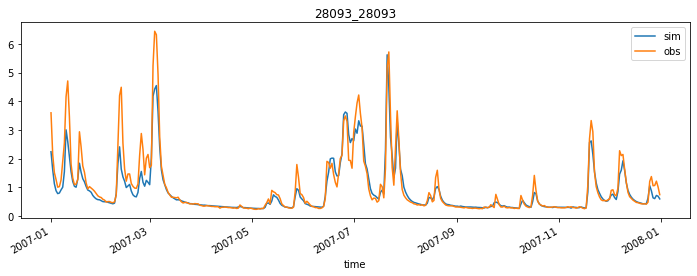

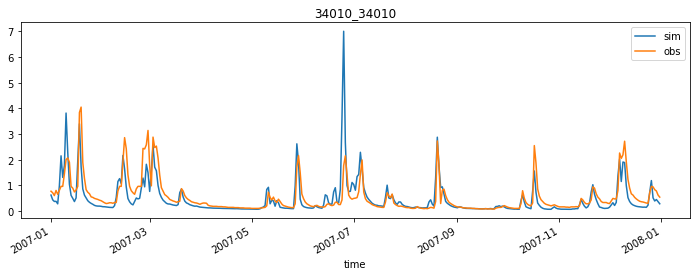

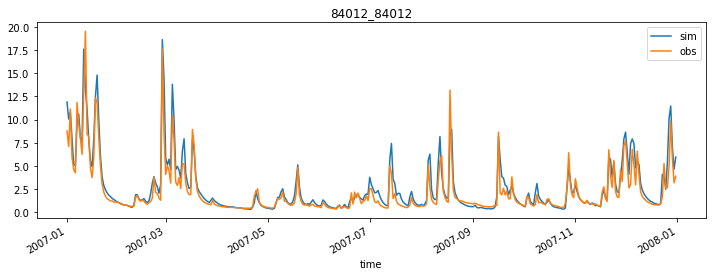

In [58]:
for i in range(5):
    f, ax = plt.subplots(figsize=(12, 4))
    pixel = np.random.choice(preds.pixel.values)
    preds.sel(time="2007", pixel=pixel).to_dataframe().plot(ax=ax)
    ax.set_title(pixel)

In [59]:
preds

<xarray.Dataset>
Dimensions:  (pixel: 671, time: 3662)
Coordinates:
  * time     (time) datetime64[ns] 1998-12-22T23:59:46.966659072 ... 2008-12-...
  * pixel    (pixel) object '10002_10002' '10003_10003' ... '97002_97002'
Data variables:
    sim      (time, pixel) float64 1.115 1.069 0.9953 ... 1.495 1.577 0.9391
    obs      (time, pixel) float64 ...

# Calculate Errors

In [60]:
%load_ext autoreload
import sys; sys.path.append("/home/tommy/neuralhydrology")
from neuralhydrology.evaluation.metrics import calculate_all_metrics, AllNaNError

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
all_errors = []
missing_data = []

pbar = tqdm(preds["pixel"].values, desc="Calculating Errors:")
for sid in pbar:
    pbar.set_postfix_str(sid)
    try:
        errors = calculate_all_metrics(
            sim=preds["sim"].rename({"pixel": "station_id", "time": "date"}).sel(station_id=sid),
            obs=preds["obs"].rename({"pixel": "station_id", "time": "date"}).sel(station_id=sid)
        )
        all_errors.append(pd.DataFrame({sid: errors}).T)
    except AllNaNError:
        missing_data.append(sid)
        
        
errors = pd.concat(all_errors).to_xarray().rename({"index": "pixel"})

Calculating Errors::  28%|██▊       | 190/671 [00:28<01:02,  7.65it/s, 30012_30012]/home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:523: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs)
Calculating Errors::  28%|██▊       | 191/671 [00:28<01:02,  7.67it/s, 30014_30014]/home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:523: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs)
Calculating Errors::  29%|██▉       | 194/671 [00:28<01:05,  7.30it/s, 31002_31002]/home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:523: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs)
Calculating Errors::  30%|██▉       | 201/671 [00:29<01:02,  7.57it/s, 32004_32004]/home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:523: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs)
Calculating Errors::  33%|███▎      | 223/671 [00:32<00:54,  8.16it/s, 33035_33035]/home/tommy/neuralhydrolo

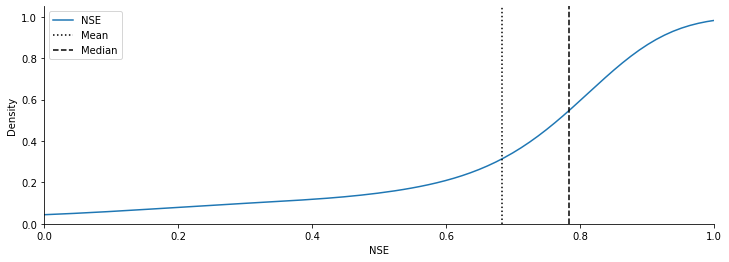

In [63]:
f, ax = plt.subplots(figsize=(12, 4))
sns.kdeplot(errors["NSE"], cumulative=True, label="NSE")
ax.axvline(errors["NSE"].mean(), color="k", ls=":", label="Mean")
ax.axvline(errors["NSE"].median(), color="k", ls="--", label="Median")
ax.set_xlim(0, 1)
plt.legend()
sns.despine()

# Run predictions on the training period and validation period (check overfitting)

In [50]:
assert False, "DO not run this automatically"

AssertionError: DO not run this automatically

In [ ]:
trainer = Trainer(cfg, ds)
tester = Tester(cfg, ds)

In [ ]:
tester.test_dl
trainer.train_dl
trainer.valid_dl

In [ ]:
if cfg.run_dir != run_dir:
    cfg.run_dir = cfg.run_dir.parent

weight_file = tester._get_weight_file(cfg, epoch=None)
epoch = int(weight_file.name.split(".")[0][-3:])

tester.model.load_state_dict(
    torch.load(weight_file, map_location=cfg.device)
)

In [ ]:
# make train data predictions
overfitting_tester = Tester(cfg, ds, subset="train")

In [ ]:
# Plot KDEs of train test val
test = ds.sel(time=slice(cfg._cfg["test_start_date"], cfg._cfg["test_end_date"]))
val = ds.sel(time=slice(cfg._cfg["validation_start_date"], cfg._cfg["validation_end_date"]))
train = ds.sel(time=slice(cfg._cfg["train_start_date"], cfg._cfg["train_end_date"]))

train_log_q = np.log((train[cfg.target_variable].values.flatten() + 1e-6))
test_log_q = np.log((test[cfg.target_variable].values.flatten() + 1e-6))
val_log_q = np.log((val[cfg.target_variable].values.flatten() + 1e-6))

sns.kdeplot(train_log_q, label="Train")
sns.kdeplot(test_log_q, label="Test")
sns.kdeplot(val_log_q, label="Validation")

ax.set_xlabel("Discharge [mm s-1 km-2]")

plt.legend()